In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time 
from itertools import product
from IPython.display import display


import pandas as pd
import altair as alt
from tqdm import tqdm

alt.renderers.enable('notebook')
alt.data_transformers.enable('json') #enables graphs with more than 5k lines. It stores info in a local file

DataTransformerRegistry.enable('json')

In [2]:
class Simulation:
    def __init__(self, genome_length, n_females, n_males, sub_rate, offsprings_per_female=1, fitness_weight=1.0, seed=None):
        self.genome_length = genome_length
        self.n_females = n_females
        self.n_males = n_males
        self.sub_rate = sub_rate
        self.offsprings_per_female = offsprings_per_female
        self.fitness_weight = fitness_weight
        self.n_female_sub = int(sub_rate * n_females)
        self.n_male_sub = int(sub_rate * n_males)
        self.powers = np.array([2**i for i in range(genome_length)])
        self.partners = np.zeros(n_females, dtype=np.int)
        if seed == None:
            seed = int(time.time())
        self.seed = seed
        np.random.seed(seed)
        
        
    def set_populations(self):
        self.females = np.random.randint(0, 2, (self.n_females, self.genome_length))
        self.males = np.random.randint(0, 2, (self.n_males, self.genome_length))
        
        
    def calculate_fitness_matrix(self):
        return - (self.females.reshape(self.n_females,1,self.genome_length) == self.males).sum(axis=2) * \
                self.fitness_weight + np.abs(self.genome_length - 2 * self.males.sum(1) )

    
    def select_partners(self):
        """
        Selects the indexes of the right male partner for every female. Equally good partners are
        randomly selected
        """
        fitness = self.calculate_fitness_matrix()
        maxes = np.max(fitness,axis=1)
        for i in range(self.n_females):
            self.partners[i] = np.random.choice(np.where(fitness[i,:] == maxes[i])[0],1)
            
       
    def generate_sons(self):
        return np.where(np.random.randint(0,2,(self.n_females * self.offsprings_per_female, self.genome_length)),
                        self.females[list(range(self.n_females)) * self.offsprings_per_female],
                        self.males[list(self.partners) * self.offsprings_per_female])
    
    
    def evolve_full_dump(self, time, stats_dt):
        #evolution of the system with a dump of all system info for statistical analysis
        stats = pd.DataFrame(columns=['sex','genome','timestep','partner','n_copulations'],
                             index=np.arange(time / stats_dt * (self.n_males + self.n_females),dtype=np.int))
        progress = 0
        for i in range(time):
            self.select_partners()
            #calculating the statistics:
            if(i % stats_dt == 0):
                for ind in range(self.n_males):
                    stats.loc[progress] = ['M', self.males[ind].dot(self.powers), i, np.nan,(self.partners==ind).sum()]
                    progress += 1
                for ind in range(self.n_females):
                    stats.loc[progress] = ['F', self.females[ind].dot(self.powers), i, self.males[self.partners[ind]].dot(self.powers),np.nan]
                    progress += 1
                
            self.evolution_step()       
        #setting the right types for the stats Dataframe
        stats.to_csv('test.csv')
    
    
    def evolution_step(self):
        #mixing the offsprings in the population NO NATURAL SELECTION IS TAKEN INTO ACCOUT 
        sons = self.generate_sons()[np.random.choice(self.n_females * self.offsprings_per_female,
                                                    self.n_female_sub + self.n_male_sub,
                                                    replace=False),:]
        self.females[np.random.choice(self.n_females,self.n_female_sub,replace=False),:] = sons[:self.n_female_sub]
        self.males[np.random.choice(self.n_males, self.n_male_sub, replace=False),:] = sons[-self.n_male_sub:]

    
    def sons_statistics(self):
#         Distribution of sons for the current male and female population.
        sons_count = np.zeros(2 ** self.genome_length)
        sons = np.zeros((2 ** self.genome_length, self.genome_length))
        self.select_partners()
        for ind in range(self.n_females):
            for son in product(*np.array([self.males[self.partners[ind]],self.females[ind]]).transpose()):
                sons_count[np.array(son).dot(self.powers)] += 1
        return sons_count
    
    def evolve_order_par_stats(self, genome_threshold, length):
        n_step = 0
        setback = 20
        stats = pd.DataFrame(columns=['r2 individuals','r2 genomes'],
                             index=np.arange(length),dtype=np.int)
        while(n_step < length):
            self.select_partners()
            stats.loc[n_step] = ((pd.Series(self.partners).value_counts()**2).sum(),
                                 (pd.Series(self.males.dot(self.powers)[self.partners]).value_counts()**2).sum())
            self.evolution_step()
            n_step += 1
            if (pd.Series(self.males.dot(self.powers)).nunique() < genome_threshold):
                if (n_step < setback):
                    n_step = 0
                else:
                    n_step -= setback
                self.set_populations()
                print("resetting populations as the system collapsed")
        return stats
        

In [68]:
# Initialization of the simulation. 
k = Simulation(genome_length=3,
               n_females=32,
               n_males=32,
               sub_rate=0.3,
               offsprings_per_female=1,
               fitness_weight=1.5
#                seed = 1558444788
               )
print(f"current seed:{k.seed}")
k.set_populations()
#MEMO> seed 1558387779 for genome length 3 , n_females/n_males = 30, sub_rate 0.3 offspring= 1 fitness 1.5 fails aroun 100k

current seed:1558693366


In [69]:
# Evolution of the system. Stats are recorded every STAT_STEP steps and are saved in test.csv
SIM_LENGTH = 500
STAT_STEP = 1
k.evolve_full_dump(SIM_LENGTH, STAT_STEP)

#preparation of the dataframe needed for visualization
stats = pd.read_csv('test.csv')
st = stats[['timestep','sex','genome']]

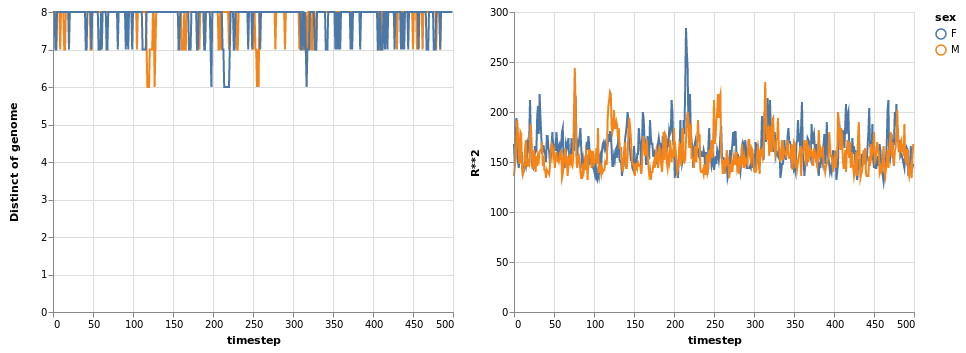

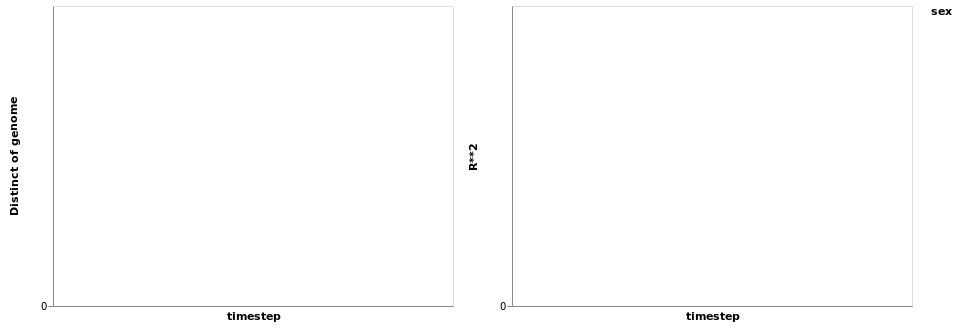

In [70]:
#visualization of variety inside the genome pool and measure of distance from uniform distribution
c1 = alt.Chart(stats[['timestep','sex','genome']]).mark_line().encode(
    x = 'timestep',
    y = 'distinct(genome)',
    color = 'sex')

r2 = st.groupby(['timestep','sex']).agg(lambda x: (x.value_counts()**2).sum()).reset_index()
c2 = alt.Chart(r2).mark_line().encode(
    x = 'timestep',
    y = alt.Y('genome',title='R**2'),
    color = 'sex')

c1 |c2

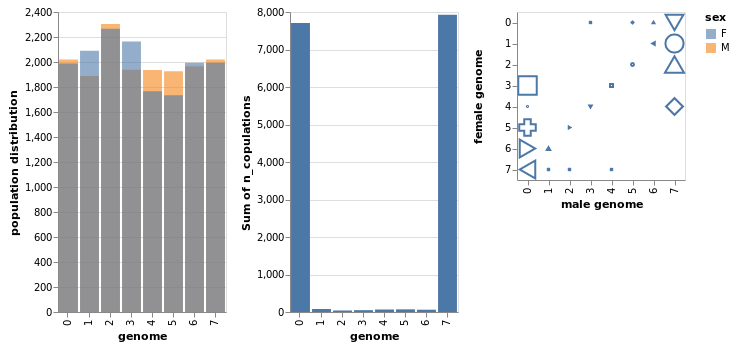

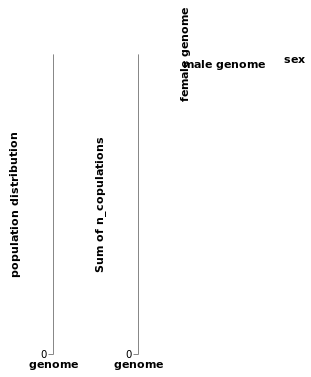

In [71]:
#visualization of populations for both sexes and reproductive success of males based on their genome

copulations = stats.drop(['partner','Unnamed: 0'],axis=1)[stats['sex'] =="M"]
slider = alt.binding_range(min=0, max=SIM_LENGTH, step=STAT_STEP)
select_timestep = alt.selection_single(name="timestep", fields=['timestep'],
                                       bind=slider)

c_pops = alt.Chart(stats).mark_bar(opacity=0.6).encode(
    x = 'genome:N',
    y = alt.Y('count()', stack=None, title='population distribution'),
    color = alt.Color('sex'),
    tooltip = 'count()'
).add_selection(
    select_timestep
).transform_filter(
    select_timestep
)

c_copulations = alt.Chart(copulations).mark_bar().encode(
    x = 'genome:N',
    y = 'sum(n_copulations)'
).add_selection(
    select_timestep
).transform_filter(
    select_timestep
)
fem_cop = stats[stats['sex'] =="F"].drop(['Unnamed: 0','n_copulations','sex'],axis=1)
c_fem_cop = alt.Chart(fem_cop).mark_point().encode(
    x = alt.X('partner:N',title='male genome'),
    y = alt.Y('genome:N',title='female genome'),
    size = alt.Size('count(genome)', legend=None),
    shape = alt.Shape('count(genome)',title='number of copulations',legend=None),
    tooltip = 'count(genome)'
).add_selection(
    select_timestep
).transform_filter(
    select_timestep
)

c_pops | c_copulations | c_fem_cop

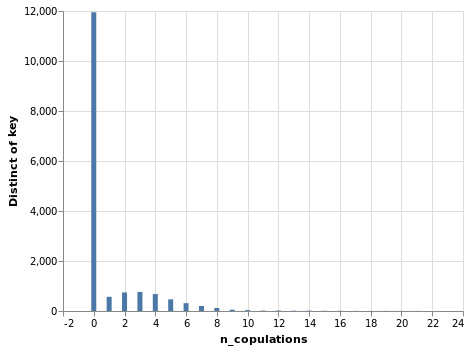

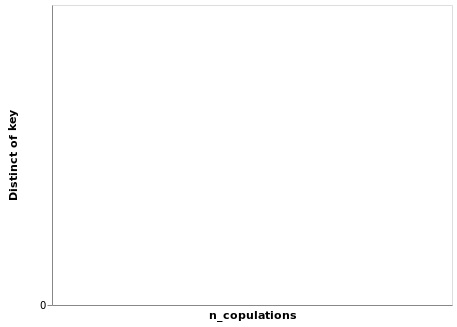

In [72]:
#Copulation distributions

"""
import powerlaw 

fit = powerlaw.Fit(cop_ind_dist[['n_copulations']],xmin=1,discrete=True,estimate_discrete=True)
fit.plot_pdf()
fit.power_law.plot_pdf(linestyle='--')"""


slider = alt.binding_range(min=0, max=SIM_LENGTH, step=STAT_STEP)
select_timestep = alt.selection_single(name="timestep", fields=['timestep'],
                                       bind=slider)

cop_ind_dist = stats.rename(columns={'Unnamed: 0':'key'})[stats['sex']=='M'].drop(['partner','sex'],axis=1)
alt.Chart(cop_ind_dist).mark_bar().encode(
    x = 'n_copulations',
    y = 'distinct(key)',
    tooltip = 'distinct(key)'
).add_selection(
    select_timestep
).transform_filter(
    select_timestep
)


In [73]:
cop_ind_dist.drop(['genome','key'],axis=1).groupby('timestep').agg(lambda x: x.dot(x)).describe()

,n_copulations
count,500.0000
mean,185.2240
std,79.5669
min,74.0000
25%,134.0000
50%,163.0000
75%,206.0000
max,562.0000


In [64]:
#Code needed to explore sons distribution at fixed female and male populations.


# # k.males = np.array( [list(np.binary_repr(n,3)) for n in range(2**3)],dtype=int)
# k.females = np.array(([0,0,0],[0,0,0]))
# plt.plot(range(8),k.sons_statistics(),label='sons genetic distribution')
# plt.hist([k.males[i].dot(k.powers) for i in k.select_partners()], bins=np.arange(-0.5,8.5,1),label='partners')
# plt.legend()

#For histograms from pd.Series use value_counts( )

means and avg:r2 individuals    191.576
r2 genomes        514.220
dtype: float64 r2 individuals    76.536527
r2 genomes        46.974086
dtype: float64


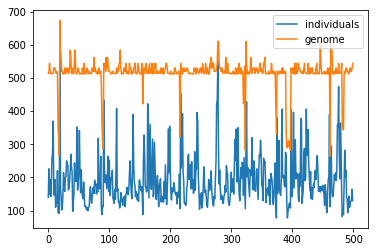

In [37]:
st = k.evolve_order_par_stats(4,500)
plt.plot(st['r2 individuals'],label='individuals')
plt.plot(st['r2 genomes'],lasbel='genome')
plt.legend()
print(f"means and avg:{st.mean()} {st.std()}")

In [7]:
#ORDER PARAMETER DETERMINATION
runs=100
length=500

points = np.zeros((3,4))
for ind, weight in zip(range(3),[1.5,2,2.5]):
    vals = np.zeros((runs,4)) #cols 0 and 1 are means, cols 2 and 3 are the stdo
    print(f'ind{ind} with weight {weight}')
    for i in tqdm(range(runs)):
        sim = Simulation(genome_length=4,
                         n_females=100,
                         n_males=100,
                         sub_rate=0.3,
                         offsprings_per_female=1,
                         fitness_weight=weight
                        )
        sim.set_populations()
        st = sim.evolve_order_par_stats(4,length)
        vals[i] = (*st.mean(), *st.std())
    points[ind] = vals.mean(axis=0)
points


  0%|          | 0/100 [00:00<?, ?it/s]

ind0 with weight 1.5



  0%|          | 0/100 [00:00<?, ?it/s]

ind1 with weight 2


  0%|          | 0/100 [00:00<?, ?it/s]

ind2 with weight 2.5


100%|██████████| 100/100 [10:03<00:00,  6.04s/it]


array([[ 787.00852   , 5070.00976   ,  235.9177176 ,  117.97970918],
       [ 344.07788   , 1710.03268   ,   48.84679302,  329.63525746],
       [ 221.22812   ,  720.34316   ,   24.48819444,   35.7059142 ]])

In [9]:
data = pd.DataFrame(columns=['weight','mean individual r2','mean genome r2','std individual r2','std genome r2'],index=range(3))
for weight, index, line in zip([1.5,2,2.5],range(3),points):
    data.loc[index] = (weight,*line)
    

In [14]:
data2 = pd.DataFrame(points,columns=['mean individual r2','mean genome r2','std individual r2','std genome r2'])

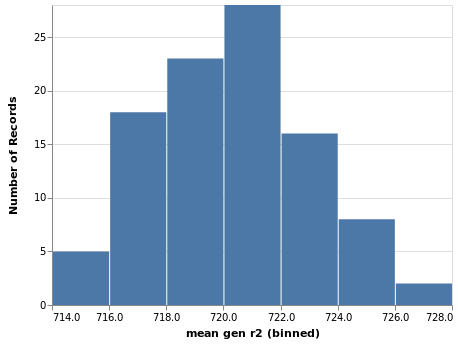

In [22]:
alt.Chart(pd.DataFrame(vals,columns=['mean ind r2','mean gen r2','std ind','std gen'])).mark_bar().encode(
    x = alt.X('mean gen r2',bin=True),
    y = 'count()')

In [16]:
data.to_csv('100runs500length100pop4g.csv')

In [23]:
data = np.zeros((5,3))
data[1:3,0]= 1
data

array([[0., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [24]:
a = ['a','b','c']
for ind, k in enumerate(a):
    print(ind,k)

0 a
1 b
2 c


In [34]:
#ORDER PARAMETER  DETERMINATION IMPROVED
runs = 100
length = 400
pops = [16,32,64,128]
vals = np.zeros((runs*3*len(pops),6)) 
for ind1, pop in enumerate(pops):
    for ind2, weight in enumerate([1.5,2,2.5]):
        for i in tqdm(range(runs)):
            sim = Simulation(genome_length=4,
                             n_females=pop,
                             n_males=pop,
                             sub_rate=0.3,
                             offsprings_per_female=1,
                             fitness_weight=weight
                            )
            sim.set_populations()
            st = sim.evolve_order_par_stats(4,length)
            vals[i+ind1*runs*3+ind2*runs] = (weight,pop,*st.mean(), *st.std())
results = pd.DataFrame(vals, columns=['weight','population','mean ind','mean gen','std ind','std gen'])

  0%|          | 0/100 [00:00<?, ?it/s]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

  1%|          | 1/100 [00:06<11:13,  6.81s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


  2%|▏         | 2/100 [00:12<10:17,  6.30s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

  3%|▎         | 3/100 [00:21<11:26,  7.07s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


  4%|▍         | 4/100 [00:26<10:46,  6.74s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

  5%|▌         | 5/100 [00:33<10:30,  6.64s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

  6%|▌         | 6/100 [00:39<10:24,  6.64s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

  7%|▋         | 7/100 [00:47<10:25,  6.73s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

  8%|▊         | 8/100 [00:54<10:24,  6.79s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

  9%|▉         | 9/100 [01:02<10:32,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 10%|█         | 10/100 [01:08<10:16,  6.85s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 11%|█         | 11/100 [01:15<10:14,  6.90s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 12%|█▏        | 12/100 [01:21<09:58,  6.81s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 13%|█▎        | 13/100 [01:28<09:54,  6.84s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 14%|█▍        | 14/100 [01:36<09:51,  6.88s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 15%|█▌        | 15/100 [01:42<09:43,  6.86s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 16%|█▌        | 16/100 [01:49<09:36,  6.86s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 17%|█▋        | 17/100 [01:56<09:27,  6.84s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 18%|█▊        | 18/100 [02:04<09:27,  6.92s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 19%|█▉        | 19/100 [02:11<09:22,  6.94s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 20%|██        | 20/100 [02:19<09:16,  6.96s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 21%|██        | 21/100 [02:26<09:10,  6.97s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 22%|██▏       | 22/100 [02:32<09:01,  6.94s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 23%|██▎       | 23/100 [02:39<08:55,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 24%|██▍       | 24/100 [02:46<08:46,  6.93s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 25%|██▌       | 25/100 [02:52<08:36,  6.88s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 26%|██▌       | 26/100 [02:57<08:24,  6.82s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 27%|██▋       | 27/100 [03:07<08:27,  6.96s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 28%|██▊       | 28/100 [03:12<08:16,  6.89s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 29%|██▉       | 29/100 [03:20<08:10,  6.90s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 30%|███       | 30/100 [03:26<08:02,  6.90s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 31%|███       | 31/100 [03:33<07:54,  6.87s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 32%|███▏      | 32/100 [03:40<07:48,  6.89s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 33%|███▎      | 33/100 [03:47<07:42,  6.90s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 34%|███▍      | 34/100 [03:54<07:34,  6.89s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 35%|███▌      | 35/100 [04:00<07:26,  6.87s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 36%|███▌      | 36/100 [04:07<07:19,  6.86s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 37%|███▋      | 37/100 [04:12<07:10,  6.83s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 38%|███▊      | 38/100 [04:18<07:02,  6.81s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 39%|███▉      | 39/100 [04:24<06:53,  6.78s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 40%|████      | 40/100 [04:30<06:45,  6.76s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 41%|████      | 41/100 [04:37<06:39,  6.76s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 42%|████▏     | 42/100 [04:46<06:35,  6.82s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 43%|████▎     | 43/100 [04:53<06:29,  6.83s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 44%|████▍     | 44/100 [05:01<06:23,  6.85s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 45%|████▌     | 45/100 [05:09<06:18,  6.89s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 46%|████▌     | 46/100 [05:17<06:12,  6.89s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 47%|████▋     | 47/100 [05:24<06:06,  6.91s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 48%|████▊     | 48/100 [05:31<05:59,  6.91s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 49%|████▉     | 49/100 [05:37<05:51,  6.89s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 50%|█████     | 50/100 [05:45<05:45,  6.90s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 51%|█████     | 51/100 [05:51<05:37,  6.90s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 52%|█████▏    | 52/100 [05:56<05:29,  6.86s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 53%|█████▎    | 53/100 [06:03<05:22,  6.87s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 54%|█████▍    | 54/100 [06:10<05:15,  6.86s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 55%|█████▌    | 55/100 [06:17<05:08,  6.86s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 56%|█████▌    | 56/100 [06:25<05:02,  6.88s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 57%|█████▋    | 57/100 [06:31<04:55,  6.87s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 58%|█████▊    | 58/100 [06:39<04:49,  6.89s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 59%|█████▉    | 59/100 [06:46<04:42,  6.89s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 60%|██████    | 60/100 [06:53<04:35,  6.89s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 61%|██████    | 61/100 [06:59<04:28,  6.88s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 62%|██████▏   | 62/100 [07:07<04:22,  6.90s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 63%|██████▎   | 63/100 [07:14<04:15,  6.90s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 64%|██████▍   | 64/100 [07:20<04:08,  6.89s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 65%|██████▌   | 65/100 [07:27<04:00,  6.88s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 66%|██████▌   | 66/100 [07:34<03:54,  6.89s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 67%|██████▋   | 67/100 [07:42<03:47,  6.90s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 68%|██████▊   | 68/100 [07:49<03:40,  6.90s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 69%|██████▉   | 69/100 [07:54<03:33,  6.88s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 70%|███████   | 70/100 [08:03<03:27,  6.91s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 71%|███████   | 71/100 [08:10<03:20,  6.91s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 72%|███████▏  | 72/100 [08:17<03:13,  6.91s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 73%|███████▎  | 73/100 [08:24<03:06,  6.91s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 74%|███████▍  | 74/100 [08:29<02:58,  6.88s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 75%|███████▌  | 75/100 [08:36<02:52,  6.88s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 76%|███████▌  | 76/100 [08:42<02:44,  6.87s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 77%|███████▋  | 77/100 [08:49<02:38,  6.87s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 78%|███████▊  | 78/100 [08:55<02:31,  6.87s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 79%|███████▉  | 79/100 [09:02<02:24,  6.87s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 80%|████████  | 80/100 [09:11<02:17,  6.90s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 81%|████████  | 81/100 [09:19<02:11,  6.91s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 82%|████████▏ | 82/100 [09:26<02:04,  6.91s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 83%|████████▎ | 83/100 [09:33<01:57,  6.91s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 84%|████████▍ | 84/100 [09:43<01:51,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 85%|████████▌ | 85/100 [09:50<01:44,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 86%|████████▌ | 86/100 [09:58<01:37,  6.96s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 87%|████████▋ | 87/100 [10:04<01:30,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 88%|████████▊ | 88/100 [10:12<01:23,  6.96s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 89%|████████▉ | 89/100 [10:18<01:16,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 90%|█████████ | 90/100 [10:25<01:09,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 91%|█████████ | 91/100 [10:32<01:02,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 92%|█████████▏| 92/100 [10:39<00:55,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 93%|█████████▎| 93/100 [10:45<00:48,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 94%|█████████▍| 94/100 [10:53<00:41,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 95%|█████████▌| 95/100 [10:59<00:34,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 96%|█████████▌| 96/100 [11:07<00:27,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 97%|█████████▋| 97/100 [11:13<00:20,  6.94s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 98%|█████████▊| 98/100 [11:20<00:13,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

 99%|█████████▉| 99/100 [11:28<00:06,  6.95s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the syste

  0%|          | 0/100 [00:00<?, ?it/s]

resetting populations as the system collapsed


  1%|          | 1/100 [00:02<04:39,  2.82s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


  2%|▏         | 2/100 [00:05<04:42,  2.88s/it]

resetting populations as the system collapsed


  3%|▎         | 3/100 [00:08<04:36,  2.85s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


  4%|▍         | 4/100 [00:11<04:42,  2.94s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


  5%|▌         | 5/100 [00:14<04:40,  2.96s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


  6%|▌         | 6/100 [00:17<04:40,  2.98s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


  7%|▋         | 7/100 [00:21<04:39,  3.00s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


  8%|▊         | 8/100 [00:23<04:34,  2.99s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


  9%|▉         | 9/100 [00:27<04:34,  3.01s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 10%|█         | 10/100 [00:30<04:31,  3.01s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 11%|█         | 11/100 [00:33<04:30,  3.04s/it]

resetting populations as the system collapsed


 12%|█▏        | 12/100 [00:36<04:26,  3.03s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 13%|█▎        | 13/100 [00:39<04:25,  3.06s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 14%|█▍        | 14/100 [00:43<04:24,  3.07s/it]

resetting populations as the system collapsed


 15%|█▌        | 15/100 [00:45<04:20,  3.06s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 16%|█▌        | 16/100 [00:49<04:18,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 17%|█▋        | 17/100 [00:52<04:16,  3.09s/it]

resetting populations as the system collapsed


 18%|█▊        | 18/100 [00:55<04:12,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 19%|█▉        | 19/100 [00:58<04:10,  3.10s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 20%|██        | 20/100 [01:02<04:08,  3.10s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 21%|██        | 21/100 [01:05<04:04,  3.10s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 22%|██▏       | 22/100 [01:08<04:01,  3.09s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 23%|██▎       | 23/100 [01:11<04:00,  3.12s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 24%|██▍       | 24/100 [01:14<03:56,  3.11s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 25%|██▌       | 25/100 [01:17<03:53,  3.11s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 26%|██▌       | 26/100 [01:21<03:50,  3.12s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 27%|██▋       | 27/100 [01:24<03:47,  3.11s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 28%|██▊       | 28/100 [01:27<03:44,  3.12s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 29%|██▉       | 29/100 [01:30<03:41,  3.12s/it]

resetting populations as the system collapsed


 30%|███       | 30/100 [01:33<03:37,  3.10s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 31%|███       | 31/100 [01:36<03:33,  3.10s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 32%|███▏      | 32/100 [01:39<03:30,  3.10s/it]

resetting populations as the system collapsed


 33%|███▎      | 33/100 [01:41<03:27,  3.09s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 34%|███▍      | 34/100 [01:45<03:23,  3.09s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 35%|███▌      | 35/100 [01:47<03:20,  3.09s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 36%|███▌      | 36/100 [01:51<03:17,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 37%|███▋      | 37/100 [01:54<03:14,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 38%|███▊      | 38/100 [01:57<03:11,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 39%|███▉      | 39/100 [02:00<03:08,  3.10s/it]

resetting populations as the system collapsed


 40%|████      | 40/100 [02:03<03:05,  3.09s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 41%|████      | 41/100 [02:06<03:02,  3.09s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 42%|████▏     | 42/100 [02:10<02:59,  3.10s/it]

resetting populations as the system collapsed


 43%|████▎     | 43/100 [02:12<02:56,  3.09s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 44%|████▍     | 44/100 [02:15<02:53,  3.09s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 45%|████▌     | 45/100 [02:19<02:49,  3.09s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 46%|████▌     | 46/100 [02:22<02:46,  3.09s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 47%|████▋     | 47/100 [02:25<02:43,  3.09s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 48%|████▊     | 48/100 [02:28<02:40,  3.09s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 49%|████▉     | 49/100 [02:31<02:37,  3.09s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 50%|█████     | 50/100 [02:34<02:34,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 51%|█████     | 51/100 [02:37<02:31,  3.08s/it]

resetting populations as the system collapsed


 52%|█████▏    | 52/100 [02:40<02:27,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 53%|█████▎    | 53/100 [02:43<02:24,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 54%|█████▍    | 54/100 [02:46<02:21,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 55%|█████▌    | 55/100 [02:49<02:18,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 57%|█████▋    | 57/100 [02:55<02:12,  3.07s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 58%|█████▊    | 58/100 [02:58<02:09,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 59%|█████▉    | 59/100 [03:01<02:06,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 60%|██████    | 60/100 [03:04<02:03,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 61%|██████    | 61/100 [03:07<02:00,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 62%|██████▏   | 62/100 [03:10<01:56,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 63%|██████▎   | 63/100 [03:14<01:53,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 64%|██████▍   | 64/100 [03:17<01:50,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 65%|██████▌   | 65/100 [03:20<01:47,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 66%|██████▌   | 66/100 [03:23<01:44,  3.08s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 67%|██████▋   | 67/100 [03:26<01:41,  3.08s/it]

resetting populations as the system collapsed


 68%|██████▊   | 68/100 [03:29<01:38,  3.07s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 69%|██████▉   | 69/100 [03:32<01:35,  3.08s/it]

resetting populations as the system collapsed


 70%|███████   | 70/100 [03:34<01:32,  3.07s/it]

resetting populations as the system collapsed


 71%|███████   | 71/100 [03:37<01:28,  3.07s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 72%|███████▏  | 72/100 [03:40<01:25,  3.07s/it]

resetting populations as the system collapsed


 73%|███████▎  | 73/100 [03:43<01:22,  3.06s/it]

resetting populations as the system collapsed


 74%|███████▍  | 74/100 [03:46<01:19,  3.06s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 75%|███████▌  | 75/100 [03:49<01:16,  3.06s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 76%|███████▌  | 76/100 [03:52<01:13,  3.05s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 77%|███████▋  | 77/100 [03:55<01:10,  3.06s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 78%|███████▊  | 78/100 [03:58<01:07,  3.06s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 79%|███████▉  | 79/100 [04:01<01:04,  3.06s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 80%|████████  | 80/100 [04:04<01:01,  3.06s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 81%|████████  | 81/100 [04:07<00:58,  3.06s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 82%|████████▏ | 82/100 [04:10<00:55,  3.06s/it]

resetting populations as the system collapsed


 83%|████████▎ | 83/100 [04:13<00:51,  3.05s/it]

resetting populations as the system collapsed


 84%|████████▍ | 84/100 [04:16<00:48,  3.05s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 85%|████████▌ | 85/100 [04:19<00:45,  3.05s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 86%|████████▌ | 86/100 [04:22<00:42,  3.05s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 87%|████████▋ | 87/100 [04:25<00:39,  3.05s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 88%|████████▊ | 88/100 [04:28<00:36,  3.05s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 89%|████████▉ | 89/100 [04:31<00:33,  3.05s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 90%|█████████ | 90/100 [04:34<00:30,  3.05s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 91%|█████████ | 91/100 [04:37<00:27,  3.05s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 92%|█████████▏| 92/100 [04:40<00:24,  3.05s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 94%|█████████▍| 94/100 [04:46<00:18,  3.05s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 95%|█████████▌| 95/100 [04:49<00:15,  3.05s/it]

resetting populations as the system collapsed


 96%|█████████▌| 96/100 [04:52<00:12,  3.04s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 97%|█████████▋| 97/100 [04:55<00:09,  3.04s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 98%|█████████▊| 98/100 [04:58<00:06,  3.04s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 99%|█████████▉| 99/100 [05:01<00:03,  3.04s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


  0%|          | 0/100 [00:00<?, ?it/s]

resetting populations as the system collapsed


  1%|          | 1/100 [00:03<04:58,  3.02s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


  2%|▏         | 2/100 [00:06<05:33,  3.40s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


  3%|▎         | 3/100 [00:10<05:42,  3.53s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


  4%|▍         | 4/100 [00:14<05:38,  3.53s/it]

resetting populations as the system collapsed


  5%|▌         | 5/100 [00:17<05:28,  3.46s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


  6%|▌         | 6/100 [00:20<05:27,  3.48s/it]

resetting populations as the system collapsed


  7%|▋         | 7/100 [00:23<05:18,  3.42s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


  8%|▊         | 8/100 [00:27<05:16,  3.44s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


  9%|▉         | 9/100 [00:30<05:11,  3.42s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 10%|█         | 10/100 [00:34<05:07,  3.41s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 11%|█         | 11/100 [00:37<05:02,  3.40s/it]

resetting populations as the system collapsed


 12%|█▏        | 12/100 [00:40<04:57,  3.38s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 13%|█▎        | 13/100 [00:44<04:55,  3.39s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 14%|█▍        | 14/100 [00:47<04:51,  3.39s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 15%|█▌        | 15/100 [00:51<04:49,  3.41s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 16%|█▌        | 16/100 [00:54<04:48,  3.43s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 17%|█▋        | 17/100 [00:58<04:46,  3.45s/it]

resetting populations as the system collapsed


 18%|█▊        | 18/100 [01:01<04:41,  3.43s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 19%|█▉        | 19/100 [01:05<04:38,  3.44s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 20%|██        | 20/100 [01:08<04:35,  3.44s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 21%|██        | 21/100 [01:12<04:33,  3.46s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 22%|██▏       | 22/100 [01:16<04:30,  3.47s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 23%|██▎       | 23/100 [01:20<04:28,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 24%|██▍       | 24/100 [01:23<04:24,  3.47s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 25%|██▌       | 25/100 [01:27<04:22,  3.49s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 26%|██▌       | 26/100 [01:31<04:19,  3.50s/it]

resetting populations as the system collapsed


 27%|██▋       | 27/100 [01:34<04:14,  3.49s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 28%|██▊       | 28/100 [01:37<04:11,  3.50s/it]

resetting populations as the system collapsed


 29%|██▉       | 29/100 [01:41<04:07,  3.48s/it]

resetting populations as the system collapsed


 30%|███       | 30/100 [01:44<04:02,  3.47s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 31%|███       | 31/100 [01:47<04:00,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 32%|███▏      | 32/100 [01:51<03:57,  3.49s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 33%|███▎      | 33/100 [01:55<03:53,  3.49s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 34%|███▍      | 34/100 [01:58<03:50,  3.49s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 35%|███▌      | 35/100 [02:02<03:47,  3.49s/it]

resetting populations as the system collapsed


 36%|███▌      | 36/100 [02:05<03:42,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 37%|███▋      | 37/100 [02:08<03:39,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 38%|███▊      | 38/100 [02:12<03:35,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 39%|███▉      | 39/100 [02:15<03:32,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 40%|████      | 40/100 [02:20<03:30,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 41%|████      | 41/100 [02:23<03:26,  3.50s/it]

resetting populations as the system collapsed


 42%|████▏     | 42/100 [02:26<03:22,  3.49s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 43%|████▎     | 43/100 [02:30<03:19,  3.49s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 44%|████▍     | 44/100 [02:33<03:15,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 45%|████▌     | 45/100 [02:37<03:12,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 46%|████▌     | 46/100 [02:40<03:08,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 47%|████▋     | 47/100 [02:44<03:05,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 48%|████▊     | 48/100 [02:48<03:02,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 49%|████▉     | 49/100 [02:51<02:58,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 50%|█████     | 50/100 [02:54<02:54,  3.49s/it]

resetting populations as the system collapsed


 51%|█████     | 51/100 [02:57<02:50,  3.49s/it]

resetting populations as the system collapsed


 52%|█████▏    | 52/100 [03:01<02:47,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 53%|█████▎    | 53/100 [03:04<02:43,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 54%|█████▍    | 54/100 [03:07<02:40,  3.48s/it]

resetting populations as the system collapsed


 55%|█████▌    | 55/100 [03:11<02:36,  3.47s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 56%|█████▌    | 56/100 [03:14<02:33,  3.48s/it]

resetting populations as the system collapsed


 57%|█████▋    | 57/100 [03:18<02:29,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 58%|█████▊    | 58/100 [03:21<02:26,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 59%|█████▉    | 59/100 [03:25<02:22,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 60%|██████    | 60/100 [03:28<02:19,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 61%|██████    | 61/100 [03:32<02:16,  3.49s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 62%|██████▏   | 62/100 [03:36<02:12,  3.49s/it]

resetting populations as the system collapsed


 63%|██████▎   | 63/100 [03:39<02:08,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 64%|██████▍   | 64/100 [03:42<02:05,  3.48s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 65%|██████▌   | 65/100 [03:47<02:02,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 66%|██████▌   | 66/100 [03:50<01:58,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 67%|██████▋   | 67/100 [03:54<01:55,  3.51s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 68%|██████▊   | 68/100 [03:58<01:52,  3.51s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 69%|██████▉   | 69/100 [04:02<01:48,  3.51s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 70%|███████   | 70/100 [04:05<01:45,  3.51s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 71%|███████   | 71/100 [04:09<01:41,  3.51s/it]

resetting populations as the system collapsed


 72%|███████▏  | 72/100 [04:12<01:38,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 73%|███████▎  | 73/100 [04:16<01:34,  3.51s/it]

resetting populations as the system collapsed


 74%|███████▍  | 74/100 [04:19<01:31,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 75%|███████▌  | 75/100 [04:22<01:27,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 76%|███████▌  | 76/100 [04:26<01:24,  3.51s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 77%|███████▋  | 77/100 [04:30<01:20,  3.51s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 78%|███████▊  | 78/100 [04:33<01:17,  3.51s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 79%|███████▉  | 79/100 [04:37<01:13,  3.51s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 80%|████████  | 80/100 [04:41<01:10,  3.51s/it]

resetting populations as the system collapsed


 81%|████████  | 81/100 [04:44<01:06,  3.51s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 82%|████████▏ | 82/100 [04:47<01:03,  3.51s/it]

resetting populations as the system collapsed


 83%|████████▎ | 83/100 [04:50<00:59,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 84%|████████▍ | 84/100 [04:54<00:56,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 85%|████████▌ | 85/100 [04:57<00:52,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 86%|████████▌ | 86/100 [05:01<00:49,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 87%|████████▋ | 87/100 [05:04<00:45,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 88%|████████▊ | 88/100 [05:07<00:41,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 89%|████████▉ | 89/100 [05:11<00:38,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 90%|█████████ | 90/100 [05:15<00:35,  3.50s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 91%|█████████ | 91/100 [05:19<00:31,  3.51s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 92%|█████████▏| 92/100 [05:23<00:28,  3.52s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 93%|█████████▎| 93/100 [05:27<00:24,  3.52s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 94%|█████████▍| 94/100 [05:30<00:21,  3.51s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 95%|█████████▌| 95/100 [05:34<00:17,  3.52s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 96%|█████████▌| 96/100 [05:37<00:14,  3.51s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 97%|█████████▋| 97/100 [05:41<00:10,  3.52s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 98%|█████████▊| 98/100 [05:44<00:07,  3.52s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed


 99%|█████████▉| 99/100 [05:48<00:03,  3.52s/it]

resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed
resetting populations as the system collapsed


 88%|████████▊ | 88/100 [04:24<00:36,  3.00s/it]

resetting populations as the system collapsed


100%|██████████| 100/100 [08:02<00:00,  4.82s/it]


In [35]:
results.to_csv('100runs400length4g.csv')

In [60]:
results.columns

Index(['weight', 'population', 'mean ind', 'mean gen', 'std ind', 'std gen'], dtype='object')

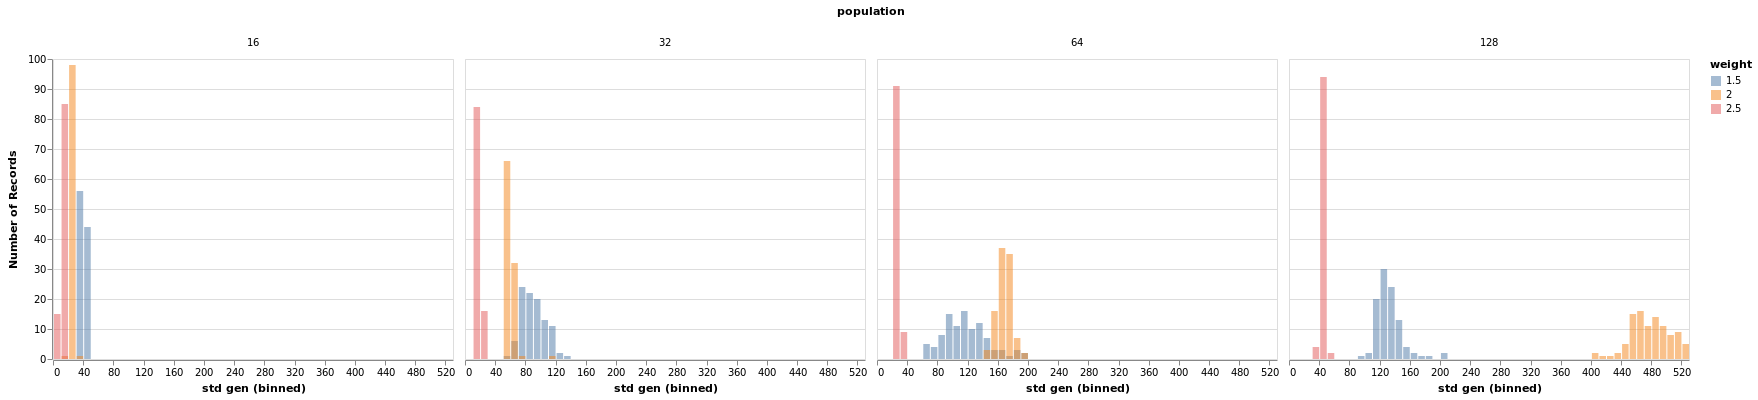

In [66]:
alt.Chart(results).mark_bar(opacity=0.5).encode(
    x= alt.X('std gen',bin=alt.BinParams(maxbins=100)),
    y = alt.Y('count(std gen)',stack=None),
    column = 'population',
    color = 'weight:N')


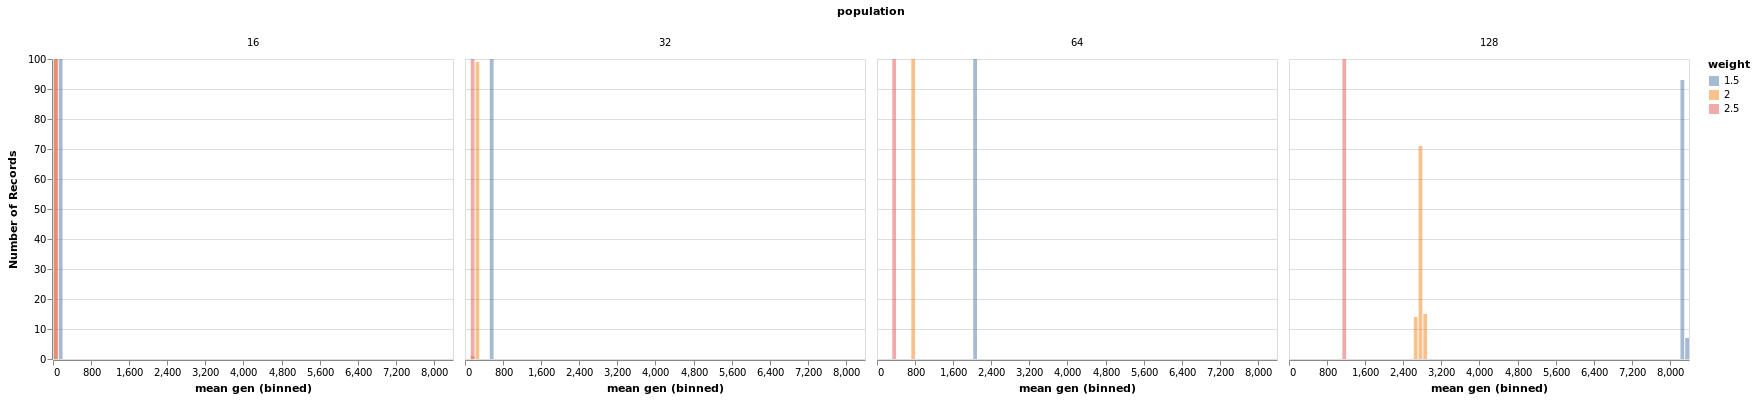

In [68]:
alt.Chart(results).mark_bar(opacity=0.5).encode(
    x= alt.X('mean gen',bin=alt.BinParams(maxbins=100)),
    y = alt.Y('count(mean gen)',stack=None),
    column = 'population',
    color = 'weight:N')



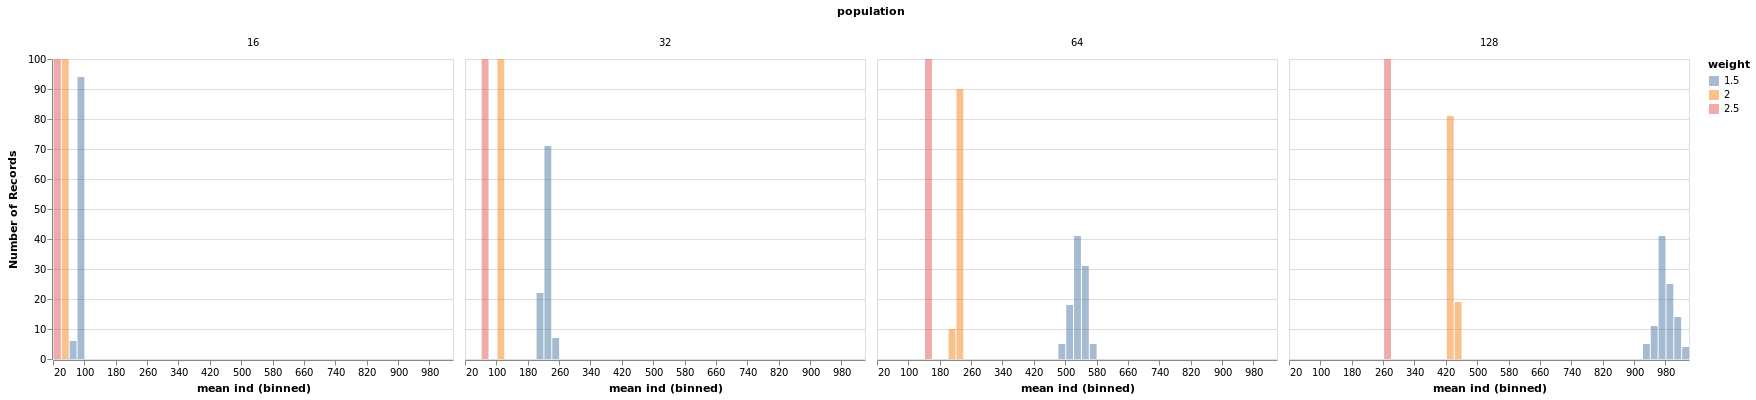

In [70]:
alt.Chart(results).mark_bar(opacity=0.5).encode(
    x= alt.X('mean ind',bin=alt.BinParams(maxbins=100)),
    y = alt.Y('count(mean ind)',stack=None),
    column = 'population',
    color = 'weight:N')



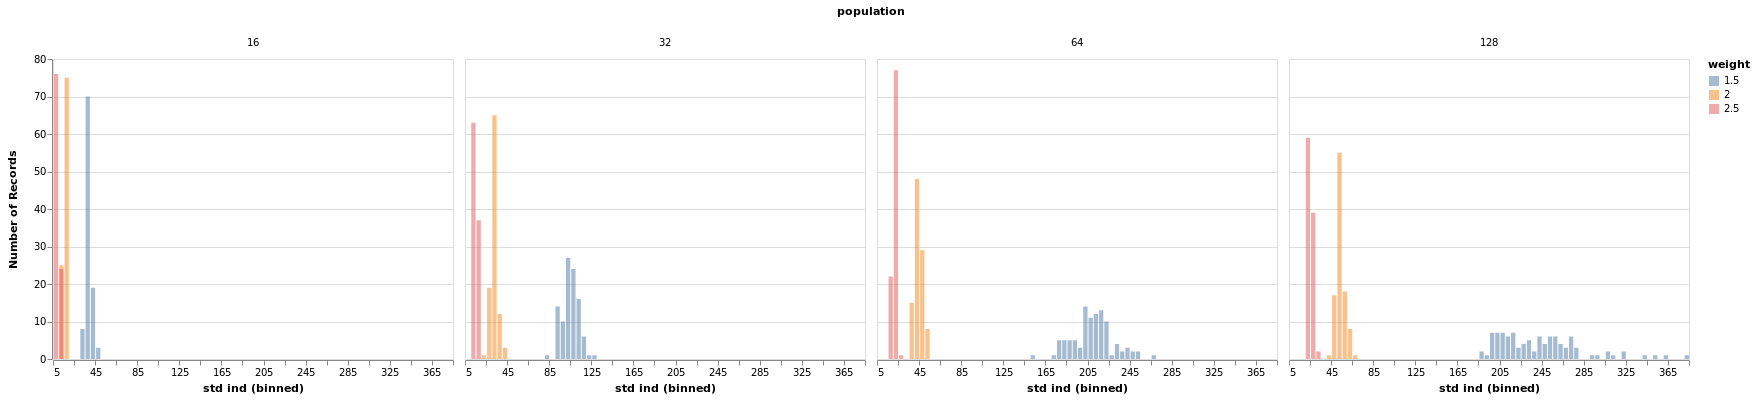

In [71]:
alt.Chart(results).mark_bar(opacity=0.5).encode(
    x= alt.X('std ind',bin=alt.BinParams(maxbins=100)),
    y = alt.Y('count(std ind)',stack=None),
    column = 'population',
    color = 'weight:N')
